In [1]:
import pandas as pd
import numpy as np

# 读取附件1数据（已整理为CSV格式）
data = pd.read_excel("附件1-共享单车分布统计表.xlsx", sheet_name="Sheet1", header=1)

# 数据清洗：处理“200+”和缺失值
data = data.replace("200+", 200).fillna(0)

# 提取所有停车点位名称
locations = data.columns[2:]  # 跳过前两列（日期和时间）

# 方法1：最大值法估算总量
total_bikes_max = data[locations].max().sum()

# 方法2：平均值法估算总量
total_bikes_mean = data[locations].mean().sum().round()

print(f"共享单车总量估算（最大值法）: {total_bikes_max} 辆")
print(f"共享单车总量估算（平均值法）: {total_bikes_mean} 辆")

共享单车总量估算（最大值法）: 1771.0 辆
共享单车总量估算（平均值法）: 369.0 辆


开始数据分析...
原始文件前3行：
    0         1    2    3   4    5    6    7     8     9     10    11     12  \
0  NaN       NaN   东门   南门  北门  一食堂  二食堂  三食堂  梅苑1栋  菊苑1栋  教学2楼  教学4楼  计算机学院   
1   周三  07:30:00  NaN  NaN  24  NaN  127  NaN    97   103   NaN   NaN      3   
2  NaN  08:50:00   68  NaN  66    3    8  NaN     6   NaN   NaN   157    NaN   

     13   14   15   16  
0  工程中心  网球场  体育馆  校医院  
1   NaN   12  NaN   11  
2    49   22    3  NaN  

使用时间列: 07:30:00
识别到停车点位: [24, 127, 97, 103, 3, 12, 11]

处理后的数据前5行：
  周三  07:30:00  Unnamed: 2  Unnamed: 3    24  Unnamed: 5    127  Unnamed: 7  \
0  0  08:50:00        68.0         0.0  66.0         3.0    8.0         0.0   
1  0  11:10:00         0.0         0.0   0.0         5.0   19.0        11.0   
2  0  12:20:00         0.0        66.0  77.0         0.0  122.0         0.0   
3  0  13:50:00        43.0         0.0  66.0        10.0    0.0         0.0   
4  0  18:00:00        36.0        99.0   0.0         0.0   80.0        65.0   

     97   103  Un

/var/folders/41/6fz3m4dj00b1d97rttf9q_6r0000gn/T/ipykernel_5753/1030330157.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['时间'] = pd.to_datetime(df[time_col].astype(str)).dt.time


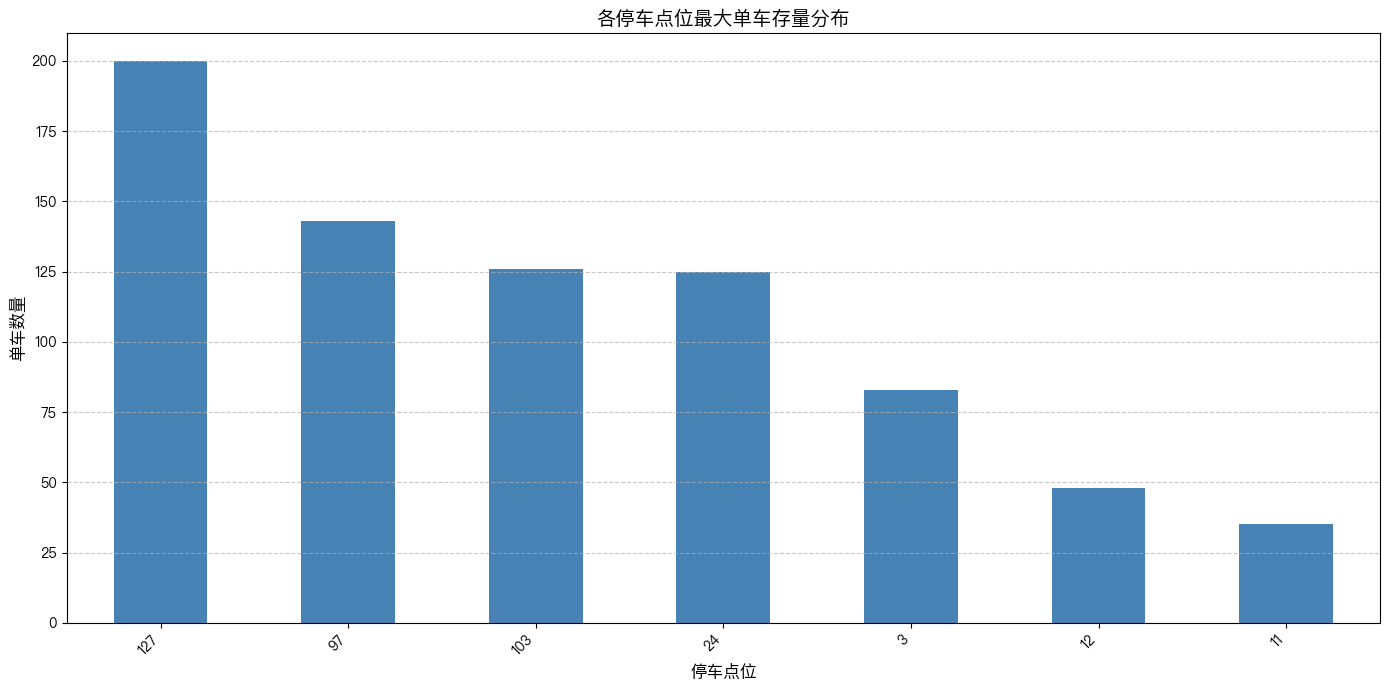

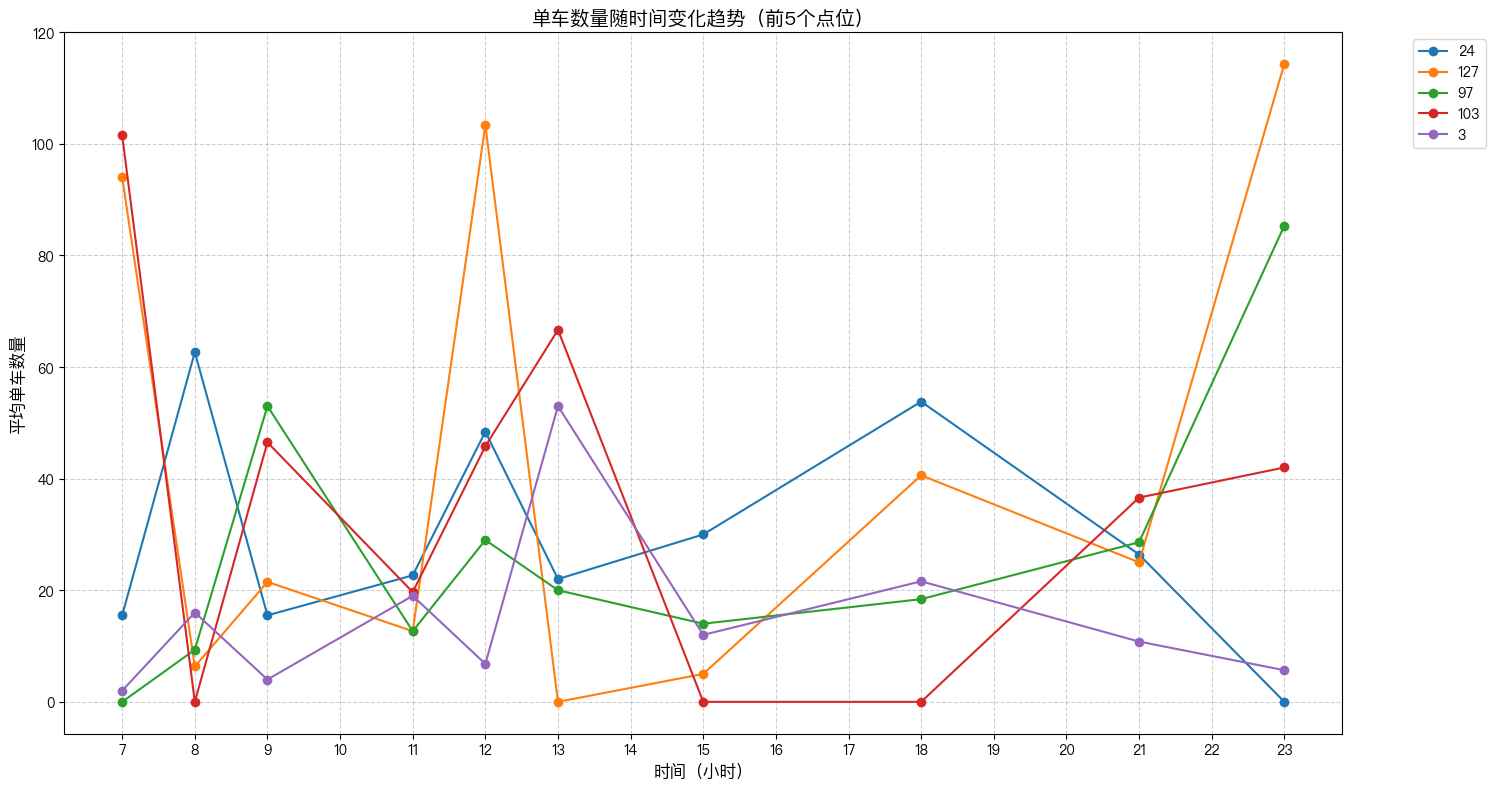


分析完成！图表已保存为PNG文件


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time

# 1. 正确读取数据
def load_data_correctly():
    # 先查看原始文件结构
    raw = pd.read_excel("附件1-共享单车分布统计表.xlsx", header=None)
    print("原始文件前3行：")
    print(raw.head(3))
    
    # 确定表头行（通常第2行是列名）
    header_row = 1
    
    # 重新读取数据，指定header行
    df = pd.read_excel("附件1-共享单车分布统计表.xlsx", header=header_row)
    
    # 清理数据：处理"200+"和空值
    df = df.replace("200+", 200).fillna(0)
    
    # 查找时间列（包含时间数据的列）
    time_col = None
    for col in df.columns:
        sample = df[col].dropna().head(5)
        if any(isinstance(x, time) for x in sample) or any(":" in str(x) for x in sample):
            time_col = col
            break
    
    if not time_col:
        time_col = df.columns[1]  # 默认第二列为时间列
    
    print(f"\n使用时间列: {time_col}")
    
    # 标准化时间格式
    df['时间'] = pd.to_datetime(df[time_col].astype(str)).dt.time
    
    # 识别停车点位列（应该是表头的第一行）
    location_cols = [col for col in df.columns 
                    if col not in [time_col, '时间', df.columns[0]] 
                    and not str(col).startswith('Unnamed')]
    
    # 如果没有识别到，则使用除时间列外的所有数值列
    if not location_cols:
        location_cols = [col for col in df.columns 
                        if pd.api.types.is_numeric_dtype(df[col]) 
                        and col not in [time_col, '时间']]
    
    print(f"识别到停车点位: {location_cols}")
    
    return df, location_cols

# 2. 数据分析和可视化
def analyze_and_visualize(df, locations):
    # 计算各点位最大存量
    max_counts = df[locations].max().sort_values(ascending=False)
    
    # 计算总量（最大值法）
    total_bikes = max_counts.sum()
    print(f"\n校园共享单车总量（最大值法）: {int(total_bikes)} 辆")
    
    # 可视化各点位最大存量
    plt.figure(figsize=(14, 7))
    max_counts.plot(kind='bar', color='steelblue')
    plt.title('各停车点位最大单车存量分布', fontsize=14)
    plt.ylabel('单车数量', fontsize=12)
    plt.xlabel('停车点位', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('max_bikes_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 时间趋势分析
    df['小时'] = df['时间'].apply(lambda x: x.hour)
    hourly_avg = df.groupby('小时')[locations].mean()
    
    plt.figure(figsize=(15, 8))
    for loc in locations[:5]:  # 只显示前5个点位
        plt.plot(hourly_avg.index, hourly_avg[loc], label=loc, marker='o')
    
    plt.title('单车数量随时间变化趋势（前5个点位）', fontsize=14)
    plt.xlabel('时间（小时）', fontsize=12)
    plt.ylabel('平均单车数量', fontsize=12)
    plt.xticks(range(7, 24))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('time_trend.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. 执行分析
try:
    print("开始数据分析...")
    df, locations = load_data_correctly()
    
    print("\n处理后的数据前5行：")
    print(df.head())
    
    analyze_and_visualize(df, locations)
    print("\n分析完成！图表已保存为PNG文件")
    
except Exception as e:
    print(f"\n分析过程中出错: {str(e)}")
    print("建议检查：")
    print("1. Excel文件路径是否正确")
    print("2. 文件是否被其他程序占用")
    print("3. 尝试手动指定header_row参数")